In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import keras

print(os.listdir("../input"))

Using TensorFlow backend.


[]


## Load from keras.datasets.cifar10

In [4]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]
print('train:{}/{} {}/{}'.format(x_train.shape, y_train.shape, type(x_train), type(y_train)))
print('test:{}/{} {}/{}'.format(x_test.shape, y_test.shape, type(x_test), type(y_test)))

train:(50000, 32, 32, 3)/(50000, 1) <class 'numpy.ndarray'>/<class 'numpy.ndarray'>
test:(10000, 32, 32, 3)/(10000, 1) <class 'numpy.ndarray'>/<class 'numpy.ndarray'>


## Preprocessing
- `data preprocessing: Normalization and Flattern to vector `
- `Label encoding : One Hot Encoding`

In [6]:
# data preprocessing: Normalization and Flattern to vector 
def preprocessing(x):
    x = x / 255.0
    return x.reshape((len(x),-1))
# Label encoding : One Hot Encoding
def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
y_train = label_OHE(y_train)
y_test = label_OHE(y_test)

In [7]:
print('train:{}/{} {}/{}'.format(x_train.shape, y_train.shape, type(x_train), type(y_train)))
print('test:{}/{} {}/{}'.format(x_test.shape, y_test.shape, type(x_test), type(y_test)))

train:(50000, 3072)/(50000, 10) <class 'numpy.ndarray'>/<class 'numpy.ndarray'>
test:(10000, 3072)/(10000, 10) <class 'numpy.ndarray'>/<class 'numpy.ndarray'>


## Create Model (MLP) 

In [42]:
h_node = [512, 256, 128]

def build_mlp(input_shape=x_train.shape[-1:],  output_shape=y_train.shape[-1],
              hidden_node_list=h_node, regulization = {'l2':1e-5} ):
    keras.backend.clear_session()

    if regulization.keys() == 'l2':
        reg = keras.regularizers.l2(regulization['l2'])
    elif regulization.keys() == 'l1':
        reg = keras.regularizers.l2(regulization['l1'])
    else:
        k = regulization.keys()
        v = list(regulization.values())[0]
        reg = keras.regularizers.l1_l2(v)
    
    input_layer = keras.layers.Input(input_shape, name='input_layer')
    for idx, h in enumerate(hidden_node_list):
        if idx == 0:
            x = keras.layers.Dense(units=h, 
                                   activation='relu',
                                   name='hidden_layer'+str(idx+1),
                                   kernel_regularizer= reg
                                  )(input_layer)
        else:
            x = keras.layers.Dense(units=h, 
                                   activation='relu',
                                   name='hidden_layer'+str(idx+1),
                                   kernel_regularizer= reg
                                  )(x)
        output_layer = keras.layers.Dense(output_shape, 
                                          activation='softmax',
                                          name='output_layer')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    model.summary()
    return model

model = build_mlp()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


## Hyper Parameters

In [43]:
#HP
EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_LIST = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

## Training
- optimizer: SGD/RMSProp/Adagrad/Adam
- loss_function: categorical_crossentropy
- metric: accuracy

In [64]:
# choose SGD
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)

def model_training(train = (x_train, y_train), valid = (x_test, y_test),
                   optimizer = optimizer, 
                   e = EPOCHS, bs = BATCH_SIZE, m = model):
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train[0], train[1], epochs=e, batch_size=bs, validation_data=valid, shuffle=True)
    
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    result = {'train_loss': train_loss,
              'valid_loss': valid_loss,
              'train_acc': train_acc,
              'valid_acc': valid_acc
             }
    return model, result


In [80]:
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
model, result_ = model_training(optimizer=optimizer, m=model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 37us/step - loss: 15.

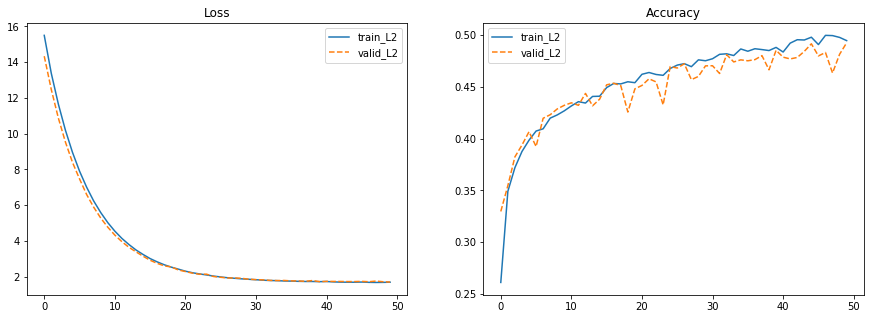

In [107]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
    
    
plot_result(result_, 'L2', ax1, ax2)
plt.show()

## L2 Search

In [83]:
EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_LIST = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

[0.1, 0.01, 0.001, 0.0001, 1e-05]

In [87]:
result_collection = {}
for L2 in L2_LIST:
    model = build_mlp(regulization={'l2':L2})
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
    model, result = model_training(optimizer=optimizer, m=model)
    result_collection['L2_'+ str(L2)] = result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 36us/step - loss: 593

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 32us/step - loss: 200.3995 - acc: 0.2251 - val_loss: 37.6827 - val_acc: 0.2683
Epoch 2/50
50000/50000 [==============================] - 1s 25us/step - loss: 16.6499 - acc: 0.1098 - val_loss: 5.3893 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 1s 24us/step - loss: 3.3645 - acc: 0.1000 - val_loss: 2.5784 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.5623 - acc: 0.0980 - val_loss: 2.5589 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.5579 - acc: 0.0978 - val_loss: 2.5568 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.5558 - acc: 0.0962 - val_loss: 2.5548 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 1s 25us/step - loss: 2.5540 - acc: 0.0984 - val_loss: 2.5531 - val

50000/50000 [==============================] - 1s 25us/step - loss: 37.2676 - acc: 0.3465 - val_loss: 31.6873 - val_acc: 0.3467
Epoch 3/50
50000/50000 [==============================] - 1s 25us/step - loss: 26.9870 - acc: 0.3553 - val_loss: 22.5808 - val_acc: 0.3580
Epoch 4/50
50000/50000 [==============================] - 1s 25us/step - loss: 18.9419 - acc: 0.3574 - val_loss: 15.5661 - val_acc: 0.3566
Epoch 5/50
50000/50000 [==============================] - 1s 25us/step - loss: 12.8609 - acc: 0.3562 - val_loss: 10.3967 - val_acc: 0.3560
Epoch 6/50
50000/50000 [==============================] - 1s 25us/step - loss: 8.5301 - acc: 0.3506 - val_loss: 6.8884 - val_acc: 0.3469
Epoch 7/50
50000/50000 [==============================] - 1s 24us/step - loss: 5.7827 - acc: 0.3323 - val_loss: 4.8753 - val_acc: 0.3267
Epoch 8/50
50000/50000 [==============================] - 1s 25us/step - loss: 4.3548 - acc: 0.3160 - val_loss: 3.9398 - val_acc: 0.3087
Epoch 9/50
50000/50000 [====================

Epoch 4/50
50000/50000 [==============================] - 1s 25us/step - loss: 12.1454 - acc: 0.3863 - val_loss: 11.3105 - val_acc: 0.3889
Epoch 5/50
50000/50000 [==============================] - 1s 27us/step - loss: 10.5664 - acc: 0.3969 - val_loss: 9.8546 - val_acc: 0.3976
Epoch 6/50
50000/50000 [==============================] - 1s 27us/step - loss: 9.2247 - acc: 0.4014 - val_loss: 8.6227 - val_acc: 0.4027
Epoch 7/50
50000/50000 [==============================] - 1s 27us/step - loss: 8.0850 - acc: 0.4092 - val_loss: 7.5776 - val_acc: 0.4049
Epoch 8/50
50000/50000 [==============================] - 1s 27us/step - loss: 7.1127 - acc: 0.4145 - val_loss: 6.6845 - val_acc: 0.4055
Epoch 9/50
50000/50000 [==============================] - 1s 26us/step - loss: 6.2847 - acc: 0.4174 - val_loss: 5.9160 - val_acc: 0.4136
Epoch 10/50
50000/50000 [==============================] - 1s 27us/step - loss: 5.5779 - acc: 0.4213 - val_loss: 5.2533 - val_acc: 0.4278
Epoch 11/50
50000/50000 [============

Epoch 6/50
50000/50000 [==============================] - 1s 25us/step - loss: 7.9062 - acc: 0.4020 - val_loss: 7.4351 - val_acc: 0.3964
Epoch 7/50
50000/50000 [==============================] - 1s 25us/step - loss: 7.0076 - acc: 0.4079 - val_loss: 6.6058 - val_acc: 0.4069
Epoch 8/50
50000/50000 [==============================] - 1s 25us/step - loss: 6.2404 - acc: 0.4141 - val_loss: 5.8882 - val_acc: 0.4182
Epoch 9/50
50000/50000 [==============================] - 1s 25us/step - loss: 5.5895 - acc: 0.4164 - val_loss: 5.3317 - val_acc: 0.4100
Epoch 10/50
50000/50000 [==============================] - 1s 25us/step - loss: 5.0305 - acc: 0.4207 - val_loss: 4.7759 - val_acc: 0.4257
Epoch 11/50
50000/50000 [==============================] - 1s 26us/step - loss: 4.5567 - acc: 0.4270 - val_loss: 4.3338 - val_acc: 0.4302
Epoch 12/50
50000/50000 [==============================] - 1s 25us/step - loss: 4.1417 - acc: 0.4314 - val_loss: 3.9618 - val_acc: 0.4318
Epoch 13/50
50000/50000 [=============

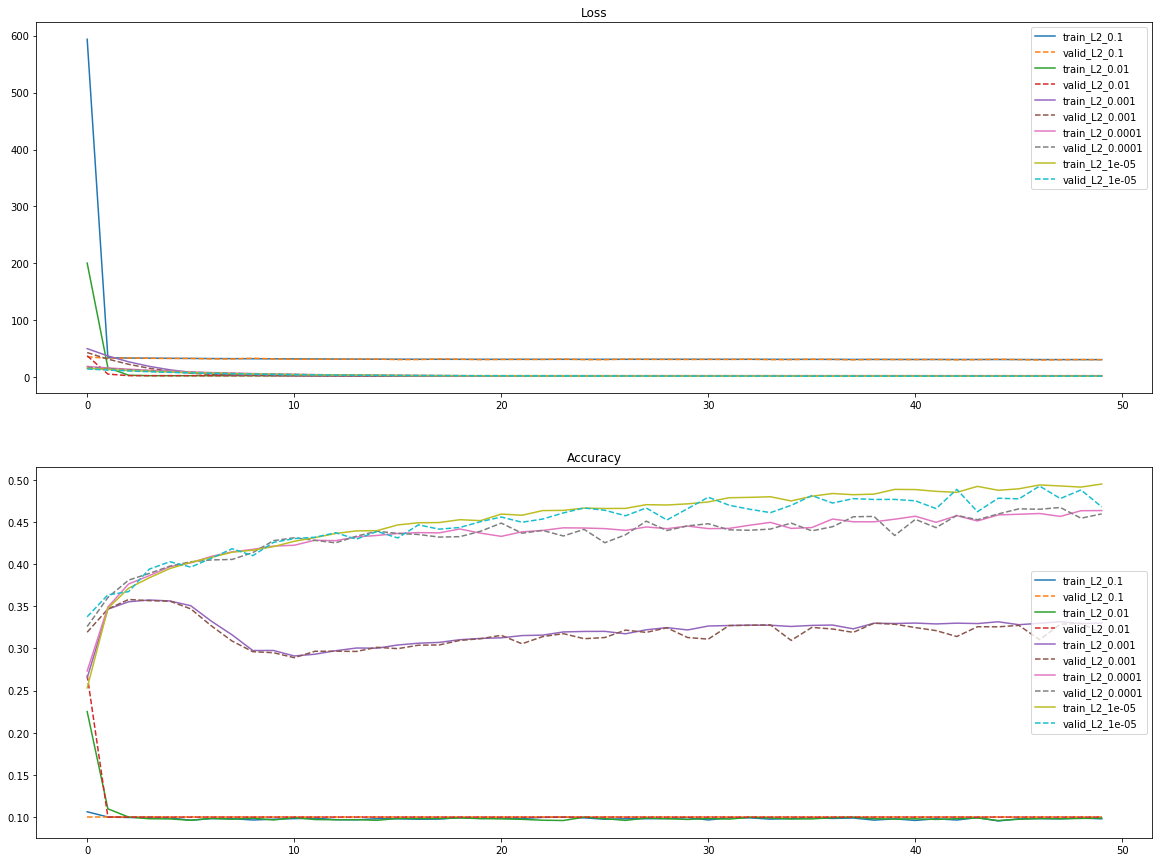

In [117]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
for k in result_collection.keys():
    plot_result(result_collection[k], k, ax1, ax2)

## L1 Search

In [97]:
EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_LIST = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

result_collection_L1 = {}
for L1 in L1_LIST:
    model = build_mlp(regulization={'l1':L1})
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
    model, result = model_training(optimizer=optimizer, m=model)
    result_collection_L1['L1_'+ str(L1)] = result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 37us/step - loss: 594

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 33us/step - loss: 200.4012 - acc: 0.2263 - val_loss: 37.7633 - val_acc: 0.2347
Epoch 2/50
50000/50000 [==============================] - 1s 25us/step - loss: 16.6828 - acc: 0.1100 - val_loss: 5.3624 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 1s 25us/step - loss: 3.3524 - acc: 0.0975 - val_loss: 2.5786 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 1s 25us/step - loss: 2.5627 - acc: 0.0974 - val_loss: 2.5596 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 1s 25us/step - loss: 2.5584 - acc: 0.0994 - val_loss: 2.5569 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 1s 25us/step - loss: 2.5564 - acc: 0.0983 - val_loss: 2.5552 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 1s 24us/step - loss: 2.5544 - acc: 0.0989 - val_loss: 2.5534 - val

50000/50000 [==============================] - 1s 24us/step - loss: 37.2370 - acc: 0.3511 - val_loss: 31.6528 - val_acc: 0.3711
Epoch 3/50
50000/50000 [==============================] - 1s 25us/step - loss: 26.9610 - acc: 0.3634 - val_loss: 22.5556 - val_acc: 0.3746
Epoch 4/50
50000/50000 [==============================] - 1s 25us/step - loss: 18.9253 - acc: 0.3674 - val_loss: 15.5533 - val_acc: 0.3708
Epoch 5/50
50000/50000 [==============================] - 1s 25us/step - loss: 12.8585 - acc: 0.3635 - val_loss: 10.3982 - val_acc: 0.3610
Epoch 6/50
50000/50000 [==============================] - 1s 25us/step - loss: 8.5390 - acc: 0.3557 - val_loss: 6.9038 - val_acc: 0.3493
Epoch 7/50
50000/50000 [==============================] - 1s 25us/step - loss: 5.8022 - acc: 0.3409 - val_loss: 4.8962 - val_acc: 0.3349
Epoch 8/50
50000/50000 [==============================] - 1s 25us/step - loss: 4.3751 - acc: 0.3205 - val_loss: 3.9634 - val_acc: 0.2965
Epoch 9/50
50000/50000 [====================

Epoch 4/50
50000/50000 [==============================] - 1s 24us/step - loss: 12.1297 - acc: 0.3844 - val_loss: 11.2894 - val_acc: 0.3939
Epoch 5/50
50000/50000 [==============================] - 1s 24us/step - loss: 10.5587 - acc: 0.3920 - val_loss: 9.8462 - val_acc: 0.3973
Epoch 6/50
50000/50000 [==============================] - 1s 24us/step - loss: 9.2244 - acc: 0.3968 - val_loss: 8.6177 - val_acc: 0.4017
Epoch 7/50
50000/50000 [==============================] - 1s 24us/step - loss: 8.0834 - acc: 0.4021 - val_loss: 7.5728 - val_acc: 0.4038
Epoch 8/50
50000/50000 [==============================] - 1s 24us/step - loss: 7.1102 - acc: 0.4082 - val_loss: 6.7013 - val_acc: 0.3879
Epoch 9/50
50000/50000 [==============================] - 1s 24us/step - loss: 6.2902 - acc: 0.4089 - val_loss: 5.9167 - val_acc: 0.4109
Epoch 10/50
50000/50000 [==============================] - 1s 24us/step - loss: 5.5777 - acc: 0.4152 - val_loss: 5.2693 - val_acc: 0.4024
Epoch 11/50
50000/50000 [============

Epoch 6/50
50000/50000 [==============================] - 1s 25us/step - loss: 7.8725 - acc: 0.4082 - val_loss: 7.4010 - val_acc: 0.4077
Epoch 7/50
50000/50000 [==============================] - 1s 25us/step - loss: 6.9790 - acc: 0.4149 - val_loss: 6.5918 - val_acc: 0.4124
Epoch 8/50
50000/50000 [==============================] - 1s 25us/step - loss: 6.2170 - acc: 0.4196 - val_loss: 5.8771 - val_acc: 0.4191
Epoch 9/50
50000/50000 [==============================] - 1s 25us/step - loss: 5.5684 - acc: 0.4240 - val_loss: 5.2824 - val_acc: 0.4232
Epoch 10/50
50000/50000 [==============================] - 1s 25us/step - loss: 5.0137 - acc: 0.4275 - val_loss: 4.7557 - val_acc: 0.4347
Epoch 11/50
50000/50000 [==============================] - 1s 25us/step - loss: 4.5305 - acc: 0.4354 - val_loss: 4.3180 - val_acc: 0.4316
Epoch 12/50
50000/50000 [==============================] - 1s 25us/step - loss: 4.1273 - acc: 0.4382 - val_loss: 3.9411 - val_acc: 0.4449
Epoch 13/50
50000/50000 [=============

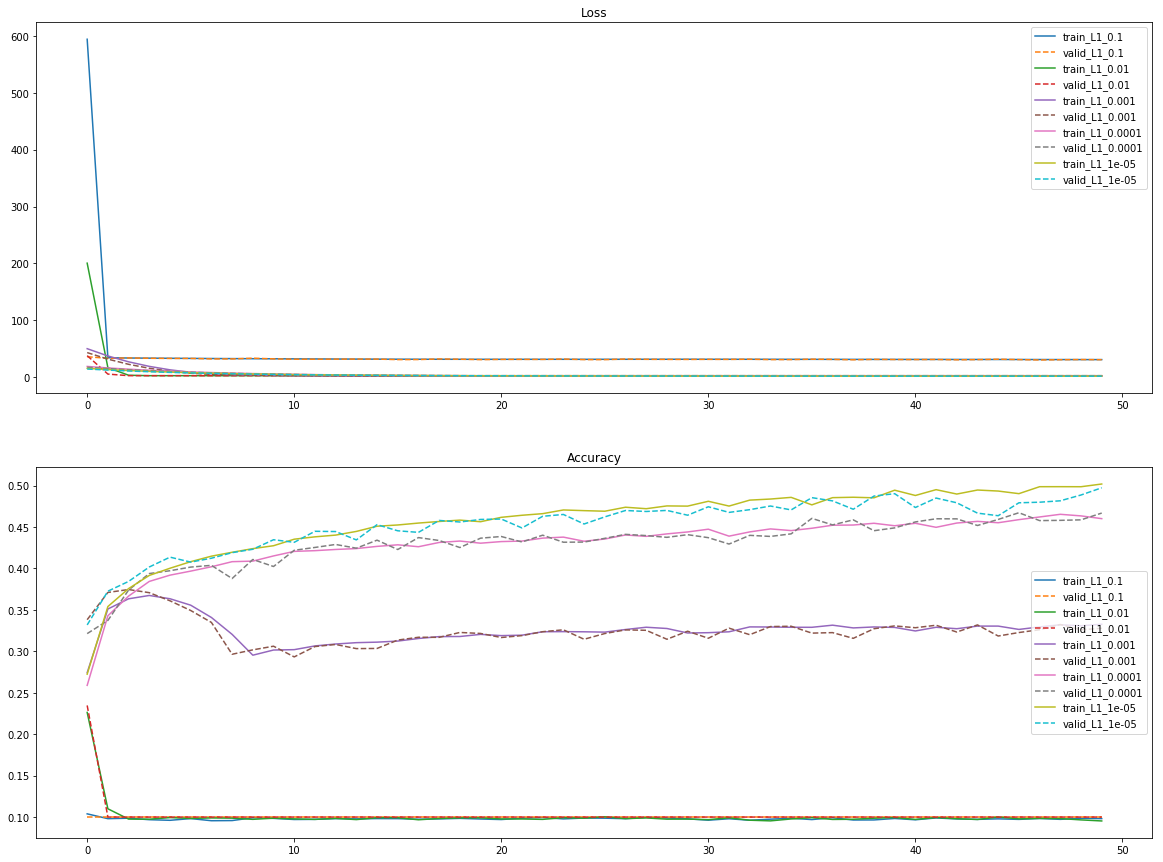

In [114]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
for k in result_collection_L1.keys():
    plot_result(result_collection_L1[k], k, ax1, ax2)

## L1_L2 Search

In [110]:
EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_LIST = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

result_collection_L1_L2 = {}
for L in L1_L2_LIST:
    model = build_mlp(regulization={'l1_l2':L})
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
    model, result = model_training(optimizer=optimizer, m=model)
    result_collection_L1_L2['L1_L2'+ str(L)] = result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 36us/step - loss: 593

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 33us/step - loss: 200.3238 - acc: 0.2322 - val_loss: 37.6662 - val_acc: 0.2031
Epoch 2/50
50000/50000 [==============================] - 1s 25us/step - loss: 16.6207 - acc: 0.1106 - val_loss: 5.3534 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 1s 27us/step - loss: 3.3528 - acc: 0.0989 - val_loss: 2.5797 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 1s 26us/step - loss: 2.5641 - acc: 0.0980 - val_loss: 2.5610 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 1s 25us/step - loss: 2.5598 - acc: 0.0962 - val_loss: 2.5586 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 1s 26us/step - loss: 2.5577 - acc: 0.0967 - val_loss: 2.5565 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 1s 25us/step - loss: 2.5559 - acc: 0.0974 - val_loss: 2.5552 - val

50000/50000 [==============================] - 1s 24us/step - loss: 37.2787 - acc: 0.3419 - val_loss: 31.6838 - val_acc: 0.3656
Epoch 3/50
50000/50000 [==============================] - 1s 24us/step - loss: 26.9908 - acc: 0.3606 - val_loss: 22.5853 - val_acc: 0.3613
Epoch 4/50
50000/50000 [==============================] - 1s 24us/step - loss: 18.9519 - acc: 0.3632 - val_loss: 15.5777 - val_acc: 0.3625
Epoch 5/50
50000/50000 [==============================] - 1s 24us/step - loss: 12.8821 - acc: 0.3561 - val_loss: 10.4294 - val_acc: 0.3497
Epoch 6/50
50000/50000 [==============================] - 1s 24us/step - loss: 8.5530 - acc: 0.3516 - val_loss: 6.9218 - val_acc: 0.3452
Epoch 7/50
50000/50000 [==============================] - 1s 24us/step - loss: 5.8058 - acc: 0.3354 - val_loss: 4.8988 - val_acc: 0.3319
Epoch 8/50
50000/50000 [==============================] - 1s 24us/step - loss: 4.3791 - acc: 0.3156 - val_loss: 3.9567 - val_acc: 0.3083
Epoch 9/50
50000/50000 [====================

Epoch 4/50
50000/50000 [==============================] - 1s 24us/step - loss: 12.1121 - acc: 0.3894 - val_loss: 11.2744 - val_acc: 0.3931
Epoch 5/50
50000/50000 [==============================] - 1s 24us/step - loss: 10.5412 - acc: 0.3957 - val_loss: 9.8270 - val_acc: 0.4013
Epoch 6/50
50000/50000 [==============================] - 1s 24us/step - loss: 9.2095 - acc: 0.4011 - val_loss: 8.6009 - val_acc: 0.4046
Epoch 7/50
50000/50000 [==============================] - 1s 24us/step - loss: 8.0659 - acc: 0.4099 - val_loss: 7.5443 - val_acc: 0.4160
Epoch 8/50
50000/50000 [==============================] - 1s 24us/step - loss: 7.0952 - acc: 0.4155 - val_loss: 6.6699 - val_acc: 0.4093
Epoch 9/50
50000/50000 [==============================] - 1s 24us/step - loss: 6.2750 - acc: 0.4174 - val_loss: 5.8935 - val_acc: 0.4192
Epoch 10/50
50000/50000 [==============================] - 1s 24us/step - loss: 5.5714 - acc: 0.4203 - val_loss: 5.2597 - val_acc: 0.4142
Epoch 11/50
50000/50000 [============

Epoch 6/50
50000/50000 [==============================] - 1s 24us/step - loss: 7.9009 - acc: 0.4048 - val_loss: 7.4359 - val_acc: 0.4077
Epoch 7/50
50000/50000 [==============================] - 1s 24us/step - loss: 7.0017 - acc: 0.4150 - val_loss: 6.5848 - val_acc: 0.4237
Epoch 8/50
50000/50000 [==============================] - 1s 24us/step - loss: 6.2335 - acc: 0.4212 - val_loss: 5.8820 - val_acc: 0.4252
Epoch 9/50
50000/50000 [==============================] - 1s 24us/step - loss: 5.5799 - acc: 0.4232 - val_loss: 5.2859 - val_acc: 0.4327
Epoch 10/50
50000/50000 [==============================] - 1s 25us/step - loss: 5.0260 - acc: 0.4274 - val_loss: 4.7628 - val_acc: 0.4338
Epoch 11/50
50000/50000 [==============================] - 1s 24us/step - loss: 4.5464 - acc: 0.4318 - val_loss: 4.3441 - val_acc: 0.4270
Epoch 12/50
50000/50000 [==============================] - 1s 25us/step - loss: 4.1344 - acc: 0.4364 - val_loss: 3.9602 - val_acc: 0.4315
Epoch 13/50
50000/50000 [=============

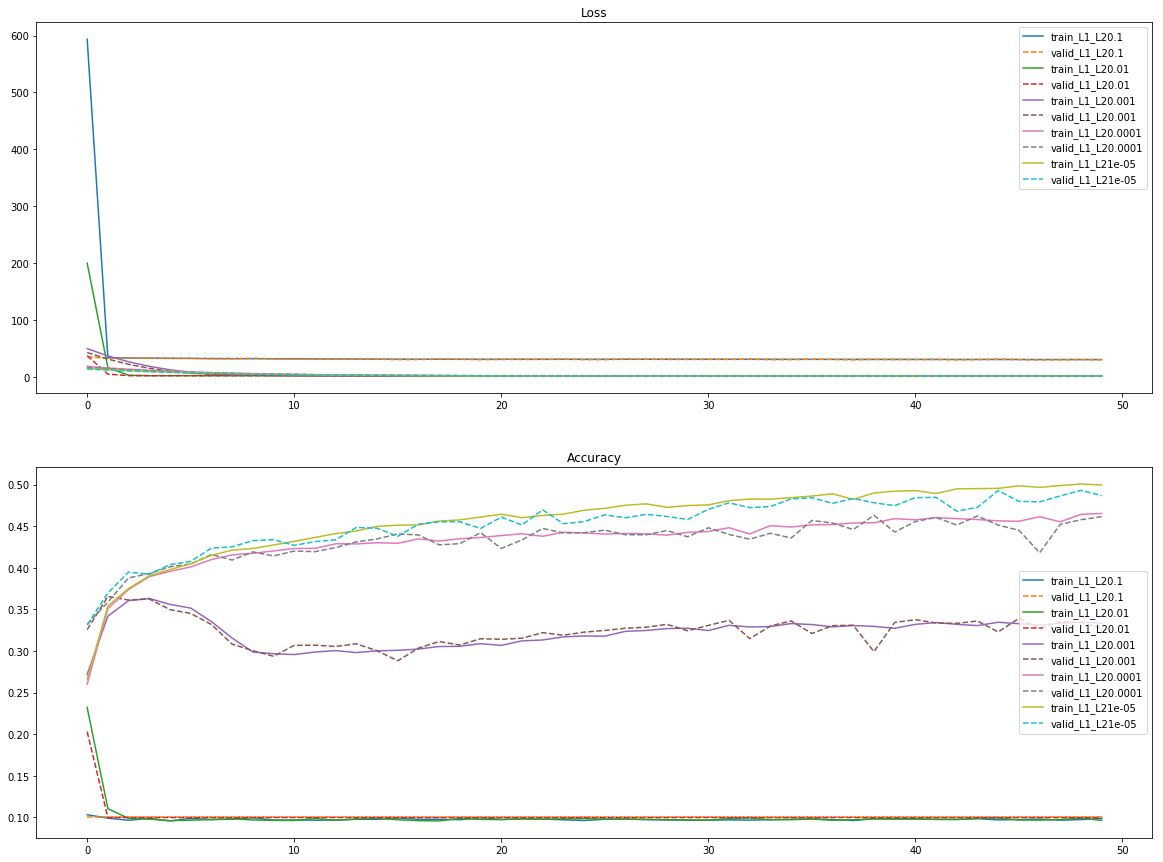

In [115]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
for k in result_collection_L1_L2.keys():
    plot_result(result_collection_L1_L2[k], k, ax1, ax2)